In [247]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import tqdm
import os
from datetime import datetime
from math import sqrt

In [248]:
# --------- VAE PARAMETERS --------------

stroke_dim = 5
Nclass = 2

# decoder 
M = 10 # number of normal distributions for output 
T = 0.1# temperature parameter
sqrtT = sqrt(T) # saves computation
dec_hidden_dim = 2048 # dimension of cell and hidden states

# encoder
enc_hidden_dim = 2048 # dimension of cell and hidden states

# --------- TRAINING PARAMETERS ----------

lr = 1e-4# Used to be 2e-3 but got NaN gradients
batch_size = 2 # batch_size >= 1, used to be 128
latent_dim = 128 # Used to be 128
n_epochs = 1500 # Used to be 150
w_kl = 0.7 # weight for loss calculation, can be tuned if needed
anneal_loss = False # True if train using annealed kl loss, False otherwise
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pretrained = False
# --------- DATA LOADING -----------------

# Get file path for one class of sketches
data_path1 = "data/axe.npz"
data_path2 = "data/anvil.npz"

dataset1 = np.load(data_path1, encoding='latin1', allow_pickle=True)
dataset2 = np.load(data_path2, encoding='latin1', allow_pickle=True)
# data = dataset["train"]
Nmax = max(
      [len(i) for i in dataset1["train"]] + [len(i) for i in dataset1["test"]]
    + [len(i) for i in dataset2["train"]] + [len(i) for i in dataset2["test"]]
    )


In [249]:
def encode_sketch(sketch,length,N): 
    ''' 
    One-hot encode pen state by adding additional columns for pen up and end of stroke.

    Parameters: 
        sketch (ndarray): n*3 array with format (x,y,p1,c), representing sketch data

    Returns: 
        ndarray: n*5 array with format (x,y,p1,p2,p3, c1,...,c_N), where p2 = 1-p1 and p3 is 1 at 
        end of the sketch, 0 otherwise.
    '''

    shape = sketch.shape
    pen_up = (np.ones(shape[0]) - sketch[:,2]).reshape(shape[0],1)
    category = np.zeros((shape[0],N))
    
    category[:,int(sketch[0][-1])] = 1
    
    end_stroke = np.zeros((shape[0],1))
    end_stroke[length:] = 1 
    pen_up[length:] = 0
    sketch[:,2][length:] = 0
    sketch[-1][2] = 0
    
    return np.concatenate((sketch[:,:-1],pen_up,end_stroke,category),axis=1)

In [250]:
def encode_dataset1(data,lengths):
    """
    Encode pen states by creating a new array of sketch data.
    
    Parameters:
        data (iterable): object containing data for each sketch
        
    Returns:
        ndarray: object array containing encoded data for each sketch
    """
    # new_data = np.empty(data.size,dtype=object)
    new_data = np.empty((data.shape[0], data.shape[1], stroke_dim+Nclass), dtype=object)

    for i, sketch in enumerate(data):
        new_data[i] = encode_sketch(sketch,lengths[i],Nclass)

    return new_data

In [251]:
class SketchesDataset():
    def __init__(self, datasets, mode, transform=None):
        """
        data_path: The path to the data
        mode: Either 'train' or 'test'
        """
        # data_path is path to one of the npz files
        # transform is not currently functional
        self.transform = transform
        self.mode = mode
        self.data_set = []
        for i, dataset in enumerate(datasets):
            dataset = dataset[mode]
            dataset = normalize_data(dataset)
            for j, sketch in enumerate(dataset):
                sketch_class = np.full((len(sketch), 1), i)
                sketch = np.concatenate([sketch, sketch_class], 1)
                self.data_set.append(sketch)

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        sketch = self.data_set[idx]
        if self.transform:
            sketch, length = self.transform(sketch)
        return sketch, length

In [252]:
def normalize_data(data):

    total_length = 0
    

    for element in data:
        total_length += (len(element))


    coordinate_list = np.empty((total_length,2))

    i = 0

    for element in data:
        coordinate_list[i:i+len(element),:] = element[:,0:2]
        i+=len(element)

    data_std = np.std(coordinate_list)

    for i, element in enumerate(data):
        data[i] = data[i].astype(np.float32)
        data[i][:,0:2] = element[:,0:2].astype(np.float32)/data_std
    
    return data


In [253]:
def display_encoded_image(image):
    """
    For some image tensor, draw the image using matplotlib.

    Parameters:
        - image: some [n*5] tensor representing a sketch.
    Returns:
        - none
    """
    #Xplot and Yplot are array of points that will be plotted
    Xplot = [0]
    Yplot = [0]
    #Keeps track of the current point that is being drawn
    xpos = 0
    ypos = 0
    #For loop to go through data and plot points
    i=0
    for i in range(len(image)):
        xpos += float(image[i,0])
        ypos += float(image[i,1])
        Xplot.append(-xpos)
        Yplot.append(-ypos)
        if image[i,3] == 0:
            plt.plot(Xplot, Yplot,color='black')
            Xplot.clear()
            Yplot.clear()
        # elif image[i, 4] == 1:
    plt.show()

In [254]:
def kl_loss(sigma_hat, mu):
    # torch.sum is added to sum over all the dimensions of the vectors
    return (-0.5 / (latent_dim * batch_size)) * torch.sum(1 + sigma_hat - torch.square(mu) - torch.exp(sigma_hat))

In [255]:
def anneal_kl_loss(num_training_steps, reconstruction_loss, kl_loss):
    # Hyperparameters
    n_min = 0.01  # Starting Value from paper
    R = 0.9995  # R is a term close to but less than 1.
    KL_min = 0.1 # Value from paper (needs to be between 0.1 and 0.5)

    # Initialize
    n_step = n_min
    total_loss = 0

    # Training loop
    for step in range(num_training_steps):
        # Calculate n_step
        n_step = 1 - (1 - n_min) * R**step

        # Calculate the total weighted loss
        step_loss = reconstruction_loss + w_kl * n_step * max(kl_loss, KL_min)
        total_loss += step_loss

    return total_loss

In [256]:
def make_image(image):
    length = len(image)
    new_image = np.zeros((Nmax, 3+Nclass-1))
    new_image[:len(image), :] = image[:len(image), :] # copy over values

    encoded_strokes = np.stack(encode_dataset1(np.array([new_image]),[length]), 1) # don't forget to stack input along dim = 1
    batch = torch.from_numpy(encoded_strokes.astype(float))
    return batch, torch.tensor(length)

In [257]:
def make_batch(size=batch_size):
    """
    Using the data created earlier in the code and a given batch size, randomly fetch
    that many images and return them + their lengths.

    Parameters:
        - size: the size of the batch. Default is the variable batch_size declared
            at the start of the code.

    Returns:
        - batch: a tensor of the batch of random images appended in the order they were fetched in.
        - lengths: the length of each image fetched, in the order they were fetched in.
    """

    batch_ids = np.random.choice(len(data), size)
    batch_images = [data[id] for id in batch_ids]
    lengths = [len(image) for image in batch_images]
    strokes = []
    for image in batch_images:
        new_image = np.zeros((Nmax, 3))
        new_image[:len(image), :] = image[:len(image), :] # copy over values
        strokes.append(new_image)

    encoded_strokes = np.stack(encode_dataset1(np.array(strokes),lengths), 1) # don't forget to stack input along dim = 1
    batch = torch.from_numpy(encoded_strokes.astype(float))
    return batch, torch.tensor(lengths)

In [258]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(stroke_dim + Nclass, enc_hidden_dim, bidirectional=True)

        self.fc_mu = nn.Linear(2*enc_hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(2*enc_hidden_dim, latent_dim)

    def forward(self, x):
        """
        Runs a batch of images through the encoder and returns its latent vector.
        Does not normalize values on its own.

        Parameters:
         - x: Tensor of shape [max_strokes, batch_size, num_features]
            where max_strokes is the highest number of points possible for an image in the batch.
            x should be normalized.
        - batch_size: int representing the current batch size.

        Returns:
        - mu: Tensor of shape [batch_size, 2*hidden dim] representing the mean of the distribution of values
        - sigma: Tensor of shape [batch_size, 2*hidden dim] representing the log of the distribution of values
        """

        # Get the hidden states
        hidden, cell = torch.zeros(2, x.shape[1], enc_hidden_dim,device=device), torch.zeros(2, x.shape[1], enc_hidden_dim,device=device)

        _, (hidden, cell) = self.lstm(x.float(), (hidden, cell))
        hidden_forward_dir, hidden_backward_dir = torch.split(hidden, 1, 0)
        hidden_concatenated = torch.cat([hidden_forward_dir.squeeze(0), hidden_backward_dir.squeeze(0)], 1)

        mu = self.fc_mu(hidden_concatenated)
        sigma = self.fc_sigma(hidden_concatenated)
        return mu, sigma

encoder = Encoder()

In [259]:
def gaussian_mixture_model(mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy):
    """
    Input:
        mixture_weights: Mixture weights (probability of a point being in distribution i)
        mean_x: The x-values of the means of each distribution
        mean_y: The y-values of the means of each distribution
        std_x: The standard deviations of the x-values
        std_y: The standard deviations of the y-values
        corr_xy: The correlation coefficients of the x and y values
        
    Return: 
        The sampled x and y offsets
    """
    # Choose which distribution to sample from
    mixture_weights = mixture_weights.squeeze().transpose(0, 1).contiguous() 
     
    # Index for each batch
    i = torch.searchsorted(mixture_weights.cumsum(0), torch.rand(batch_size, 1)).squeeze()
    
    # Sample from bivariate normal distribution i
    rand_x, rand_y = torch.randn(batch_size), torch.randn(batch_size)
    
    mean_x = torch.take(mean_x, i)
    mean_y = torch.take(mean_y, i)
    std_x = torch.take(std_x, i)
    std_y = torch.take(std_y, i)
    corr_xy = torch.take(corr_xy, i)
    
    # Alternatively torch.distributions.multivariate_normal.MultivariateNormal?
    offset_x = mean_x + std_x * rand_x
    offset_y = mean_y + std_y * (corr_xy * offset_x + torch.sqrt(1 - corr_xy ** 2) * rand_y)
    return offset_x.unsqueeze(0), offset_y.unsqueeze(0)

In [260]:
def sample(mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy, pen_state):
    offset_x, offset_y = gaussian_mixture_model(mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy)
    
    pen_state = pen_state.squeeze()
    pen_state = torch.searchsorted(pen_state.cumsum(1), torch.rand(batch_size, 1)).squeeze()
    assert(pen_state[0].item() <= 2 and pen_state[1].item() <= 2)
    next_point = torch.cat((offset_x, offset_y, torch.zeros(3, batch_size)))
    next_point = torch.cat((offset_x, offset_y, torch.eye(3)[pen_state].transpose(0, 1)))
    
    return next_point.transpose(0, 1)

In [261]:
def distribution(decoder_output):
    """
    Input: 
        decoder_output (6M + 3): Decoder LSTM output
    Return:
        mixture_weights (M): Mixture weights (probability of a point being in distribution i)
        mean_x (M): The x-values of the means of each distribution
        mean_y (M): The y-values of the means of each distribution
        std_x (M): The standard deviations of the x-values
        std_y (M): The standard deviations of the y-values
        corr_xy (M): The correlation coefficients of the x and y values
        q (3): The predicted pen state (pen_down, pen_up, <EOS>)
    """
    # Split the decoder output into 
    # [pi, mean_x, mean_y, std_x, std_y, rho_xy] and [q1,q2,q3]
    parameters = torch.split(decoder_output, 6, 2)

    # Chunk the parameters together, then stack them 
    # so that each column defines a distribution
    mixture_parameters = torch.stack(parameters[:-1],1)

    # Split mixture parameters into each parameter
    mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy = torch.split(mixture_parameters, 1, 3)

    # The 3 leftover parameters are for the pen state
    pen_state = parameters[-1]

    mixture_weights = F.softmax(mixture_weights/T,dim=3)  # Each weight must be in [0, 1] and all must sum to 1
    std_x = torch.exp(std_x)*sqrtT  # Standard deviation must be positive
    std_y = torch.exp(std_y)*sqrtT  # Standard deviation must be positive
    corr_xy = F.tanh(corr_xy)  # Correlation coefficient must be in [-1, 1]
    pen_state = F.softmax(pen_state/T,dim=2)  # Each probability must be in [0, 1] and all must sum to 1

    return mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy, pen_state

In [262]:
input_dim = latent_dim + stroke_dim + Nclass# z | (x,y,p1,p2,p3) | (c1, c2, ... c_Nclass)
output_dim = 6*M + 3

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # generates initial hidden and cell states from latent vector
        self.fc_in = nn.Linear(latent_dim,2*dec_hidden_dim)

        # Fully connected layer for reducing dimensionality of hidden state before
        # being used for distribution parameters.
        self.fc_proj = nn.Linear(dec_hidden_dim,output_dim)

        # Input has dimension latent_dim + 5 for latent vector and initial stroke
        self.lstm = nn.LSTM(input_dim,dec_hidden_dim)

        self.hidden = torch.zeros(1,batch_size,dec_hidden_dim,device=device)
        self.cell = torch.zeros(1,batch_size,dec_hidden_dim,device=device)
    
    def forward(self, z, stroke, generate):
        """
        Parameters:
            z - Tensor of size  (batch_size, latent_dim), with latent vector samples.

            stroke - Tensor of size (batch_size, stroke dim); previous stroke


        Returns:
            Tensor of size (N_max, batch_size, stroke dim), as the next stroke
        """
        
        if generate:
            x = torch.cat((z,stroke),dim = 1).view(1,batch_size,input_dim)

            out, (self.hidden, self.cell) = self.lstm(x.float(),(self.hidden.contiguous(),self.cell.contiguous()))

            # Sample from output distribution. If temperature parameter is small,
            # this becomes deterministic.
            with torch.device(device):
                params = distribution(self.fc_proj(out))
                stroke_next = sample(*params)

            return stroke_next, params
        else:
            self.hidden, self.cell = torch.split(
                F.tanh(self.fc_in(z).unsqueeze(0)),
                [dec_hidden_dim, dec_hidden_dim],
                dim = 2)

            out, (self.hidden, self.cell) = self.lstm(stroke.float(),(self.hidden.contiguous(), self.cell.contiguous()))

            params = distribution(self.fc_proj(out))

        return [i[1:] for i in params]

In [263]:
def bivariate_normal_pdf(dx, dy, mu_x, mu_y, std_x, std_y, corr_xy):
    """
    Return N(dx, dy | mu_x, mu_y, std_x, std_y, corr_xy)
    """
    z_x = (dx - mu_x) / std_x
    z_y = (dy - mu_y) / std_y
    exponent = -(z_x ** 2 - 2 * corr_xy * z_x * z_y + z_y ** 2) / (2 * (1 - corr_xy ** 2))
    norm = 2 * np.pi * std_x * std_y * torch.sqrt(1-corr_xy ** 2)
    return torch.exp(exponent) / norm


def offset_reconstruction_loss(dx, dy, pi, mu_x, mu_y, std_x, std_y, corr_xy, mask):
    """
    pi: The mixture probabilities
    mask: 1 if the point is not after the final stroke, 0 otherwise

    Returns the reconstruction loss for the strokes, L_s
    """
    pdf = bivariate_normal_pdf(dx, dy, mu_x, mu_y, std_x, std_y, corr_xy)
    
    return -torch.sum(mask[1:] * torch.log(1e-5 + torch.sum(pi*pdf,axis=0))) / (batch_size*Nmax) 


def pen_reconstruction_loss(input_pen_state, output):
    """
    Parameters:

        N_max (int) - Maximum sketch sequence length
        
        input_pen_state (batch_size,3) - Pen state data for a stroke

        output (batch_size, 3)- Generated pen state logit values.

    Returns:
        Reconstruction loss for pen state.
    """    

    return -torch.sum(input_pen_state*torch.log(1e-5+output)) / (batch_size*Nmax)

In [264]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.generate = False
    
    def run_decoder1(self,batch,lengths,z):
         # Obtain initial hidden and cell states by splitting result of fc_in along column axis
        self.decoder.hidden_cell = torch.split(
            F.tanh(self.decoder.fc_in(z).view(1,batch_size,2*dec_hidden_dim)),
            [dec_hidden_dim, dec_hidden_dim],
            dim = 2)
        
        pen_loss = 0
        offset_loss = 0

        # Data for all strokes in output sequence
        strokes = torch.zeros(Nmax + 1, batch_size, stroke_dim,device=device)
        strokes[0,:] = torch.tensor([0,0,1,0,0])
        print(strokes[0,:])
        
        mask, dx, dy, p = make_target(batch, lengths)

        # used when loop goes beyond input sketch length
        empty_stroke = torch.tensor([0,0,0,0,1]).to(torch.float32)
        
        # For each timestep, pass the batch of strokes through LSTM and compute
        # the output.  Output of the previous timestep is used as input.
        for i in range(1,Nmax):

            #params will be used for computing loss
            strokes[i], params = self.decoder(z,torch.cat((strokes[i-1],batch[i,:,5:]),dim = 1),self.generate)

            #input_stroke = batch[i]

            # calculate loss at each timestep

            #params[6] is pen_state, input_stroke is the input data
            pen_loss += pen_reconstruction_loss(p[i],params[6])

            offset_params = [params[i].view(batch_size,M) for i in range(6)]

            offset_loss += offset_reconstruction_loss(
                dx[i].view(batch_size,1),
                dy[i].view(batch_size,1),
                *offset_params,
                mask[i].view(batch_size,1)
            )
            #for strokes in generated sequence past sequence length, set to [0,0,0,0,1]
            stroke_mask = (i > lengths) # boolean mask set to false when i is larger than sketch size

            strokes[i,stroke_mask.squeeze(),:] = empty_stroke
    
        return strokes[1:], offset_loss, pen_loss

    def run_decoder2(self,batch,lengths,z):
        empty = torch.zeros(stroke_dim + Nclass)
        empty[2] = 1
        start_stroke = torch.stack([empty] * batch_size).unsqueeze(0).to(device)
        strokes = torch.cat([start_stroke, batch], 0)
        zs = torch.stack([z] * (Nmax+1))
        strokes = torch.cat([strokes,zs], 2)

        params = self.decoder(z, strokes,self.generate)

        mask, dx, dy, p = make_target(batch, lengths)
        #compute loss
        offset_params = [params[i].squeeze().transpose(0, 1) for i in range(6)]
        l_p = pen_reconstruction_loss(p, params[6]) 
        l_s = offset_reconstruction_loss(dx, dy, *offset_params, mask)
        
        output = torch.zeros(Nmax, batch_size, 5,device=device)
        with torch.device(device):
            for i in range(Nmax):
                output[i] = sample(*[j[i] for j in params])

        return output, l_s, l_p
    
    def forward(self, batch, lengths): 
        batch = batch.to(device)
        lengths = lengths.to(device) 
        
        mean, logvar = self.encoder(batch)
        
        # sample latent vector from encoder output
        random_sample = torch.randn(batch_size, latent_dim, device = device)
        std = torch.exp(logvar/2) # logvar / 2 should be a float
        z = mean + std*random_sample
        
        # Set up decoder input
        if self.generate:
            output, l_s, l_p = self.run_decoder1(batch,lengths,z)
        else:
            output, l_s, l_p = self.run_decoder2(batch,lengths,z)

        l_r = l_p + l_s
        l_kl = kl_loss(mean, logvar)
        loss = l_r + w_kl * l_kl
    
        return output, loss, l_kl, l_s, l_p

In [265]:
def make_target(batch, lengths):
    with torch.device(device):
        mask = torch.zeros((Nmax + 1, batch.size()[1]))
        for index, num_strokes in enumerate(lengths):
            mask[:num_strokes, index] = 1

        dx = batch[:, :, 0]
        dy = batch[:, :, 1]
        # copy + append together pen state values
        p = torch.stack([batch.data[:, :, 2], batch.data[:, :, 3], batch.data[:, :, 4]], 2)

        return mask, dx, dy, p

In [266]:
def save_model(dir):
    '''
    Saves model parameters to "model/temp".  An epoch is saved as t_{n}, where
    n enumerates the parameter files.  Note that these get VERY big.   
    '''
    
    try:
        os.makedirs(dir)
    except:
        pass
    
    filename = f"{str(datetime.now())}.pt"
    files = os.listdir(dir)
    
    while len(files) >= 3:
        os.remove(dir + files.pop(0))
        
    torch.save({
            "model": model.state_dict(),
            "opt": optimizer.state_dict()
        }, dir + filename)

In [267]:
train_dataset = SketchesDataset(
        datasets=[dataset1, dataset2],
        mode='train',
        transform=make_image
    )
test_dataset = SketchesDataset(
        datasets=[dataset1, dataset2],
        mode='test',
        transform=make_image
    )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [268]:
def train():
    print("Training loop running...\n")

    for epoch in range(n_epochs):
        for step, (batch, lengths) in enumerate(tqdm(train_dataloader)):
            batch = batch.squeeze(2).transpose(0, 1)

            optimizer.zero_grad()

            output, loss, l_kl, l_s, l_p = model(batch, lengths)

            loss.backward()

            grad_threshold = 1.0 # tunable parameter, prevents exploding gradient
            nn.utils.clip_grad_norm_(model.encoder.parameters(), grad_threshold)
            nn.utils.clip_grad_norm_(model.decoder.parameters(), grad_threshold)

            # update encoder and decoder parameters using adam algorithm
            optimizer.step()

            if step % 100 == 0:
                print(f"Epoch: {epoch + 1}, Step: {step + 1}, Loss: {loss.item()}")
                print(f"l_kl: {l_kl:.4f} l_s: {l_s:.4f} l_p: {l_p:.4f}") 
                print("---------------------------------------------------------\n")

            if step % 500 == 0:
                 save_model("model/temp/")

            if step % 100 == 0:
                # draw image
                display_encoded_image(output[:, 0, :])
                display_encoded_image(batch[:, 0, :])

In [269]:
model = VAE().to(device)
model.generate = False
optimizer = Adam(model.parameters(), lr = lr)    
    
if pretrained and not len(os.listdir("model/final")) == 0:
    weights = os.listdir("model/final")
    loaded_state = torch.load(f"model/final/{weights[0]}", map_location=device)
    model.load_state_dict(loaded_state['model'])
    optimizer.load_state_dict(loaded_state['opt'])



Training loop running...



  0%|          | 0/70000 [00:00<?, ?it/s]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])
Epoch: 1, Step: 1, Loss: 1.7922816506352934
l_kl: 0.0001 l_s: 0.7127 l_p: 1.0795
---------------------------------------------------------



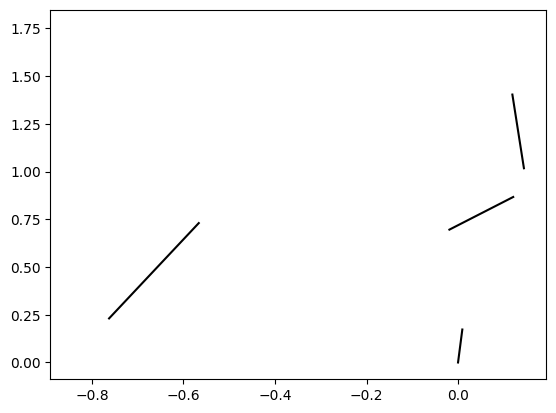

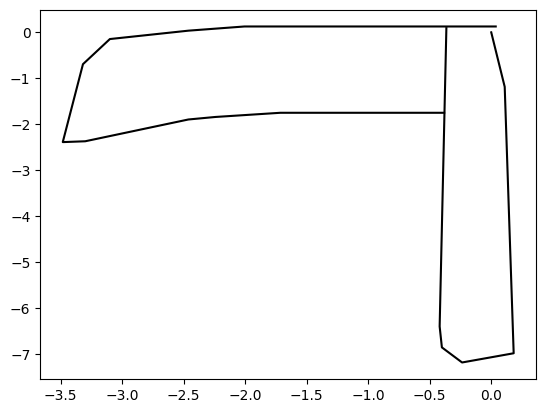

  0%|          | 1/70000 [00:02<42:40:03,  2.19s/it]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


  0%|          | 2/70000 [00:03<34:21:15,  1.77s/it]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


  0%|          | 3/70000 [00:05<32:20:22,  1.66s/it]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


  0%|          | 4/70000 [00:06<31:31:24,  1.62s/it]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


  0%|          | 5/70000 [00:08<30:48:41,  1.58s/it]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


  0%|          | 6/70000 [00:09<30:33:14,  1.57s/it]

: 

In [270]:
train()
save_model("model/final/")